In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

/content/drive/My Drive/ml-project-2-marmlla_2


In [141]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF
0,2003-09-17,5398.899902,1025.97,1.3807
1,2003-09-18,5422.600098,1039.58,1.3858


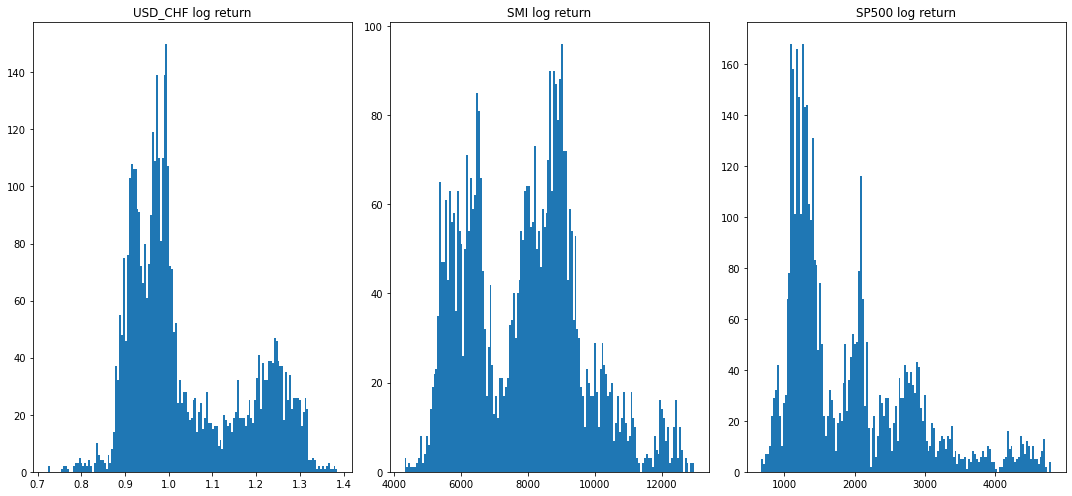

In [142]:
data = [df.USD_CHF, df.SMI, df.SP500]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF log return','SMI log return', 'SP500 log return']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

In [143]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=10, norm_=False, fraction_val_=0.1, fraction_test_=0.1)

Shape:             
X train     (3645, 10, 3), y train     (3645, 3)            
X train val (405, 10, 3) , y train val (405, 3)             
X test      (451, 10, 3) , y test      (451, 3)


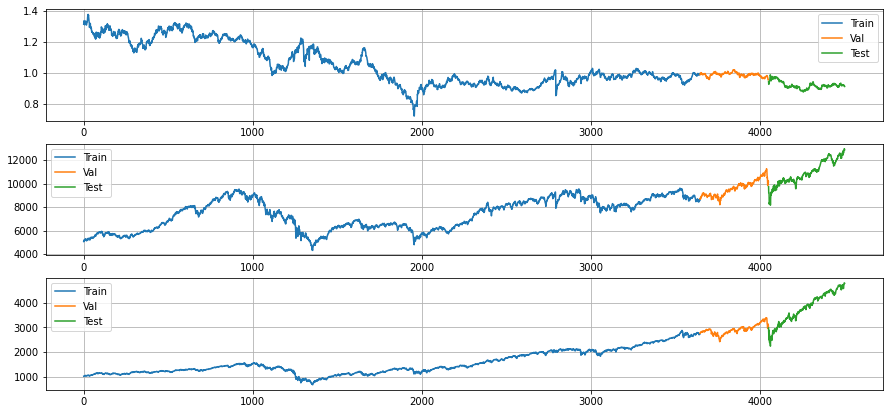

In [223]:
l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(15, 7))
for i in range(3):
  plt.subplot(3,1,i+1)
  plt.plot(np.arange(l1), train_y[:,i], label='Train')
  plt.plot(np.arange(l1, l2), val_y[:,i], label='Val')
  plt.plot(np.arange(l2,l3), test_y[:,i], label='Test')
  plt.grid()
  plt.legend()

plt.show()

# Price prediction 

### GRU (ONLY USD_CHF)

In [188]:
model_gru = ml.GRU_base(
        hidden_size=32,
        num_layers=1,
        input_size=1,
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05)
model_gru.to('cuda')
model_gru

GRU_base(
  (gru): GRU(1, 32, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [189]:
train_loss, val_loss = pl.train(model_gru, train_x[:,:,0].reshape(-1, 10,1), train_y, val_x[:,:,0].reshape(-1, 10,1), val_y, batch_size_= 512, num_epochs_=400, lr=0.0001, device_='cuda')



 21%|██        | 84/400 [00:03<00:13, 22.65it/s]

Epoch: 80/400
MSE = [train loss mean :  0.70677948] , [val loss mean:  0.59014818, MSE (last) 15.13639%]


 41%|████      | 164/400 [00:07<00:10, 22.43it/s]

Epoch: 160/400
MSE = [train loss mean :  0.05586010] , [val loss mean:  0.07724986, MSE (last) 1.16153%]


 60%|██████    | 242/400 [00:11<00:07, 22.43it/s]

Epoch: 240/400
MSE = [train loss mean :  0.00278542] , [val loss mean:  0.00159220, MSE (last) 0.02739%]


 81%|████████  | 323/400 [00:15<00:03, 22.55it/s]

Epoch: 320/400
MSE = [train loss mean :  0.00108384] , [val loss mean:  0.00043451, MSE (last) 0.05151%]


100%|██████████| 400/400 [00:18<00:00, 21.59it/s]

Epoch: 400/400
MSE = [train loss mean :  0.00077677] , [val loss mean:  0.00045497, MSE (last) 0.07731%]


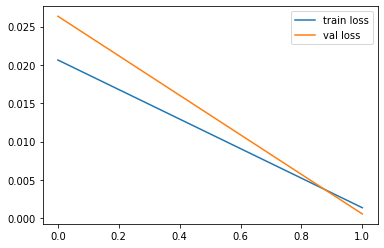

MSE: 0.021332061298804366%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     3854.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):          1.75e-222
Time:                        22:50:05   Log-Likelihood:                 1572.9
No. Observations:                 451   AIC:                            -3142.
Df Residuals:                     449   BIC:                            -3134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1958    

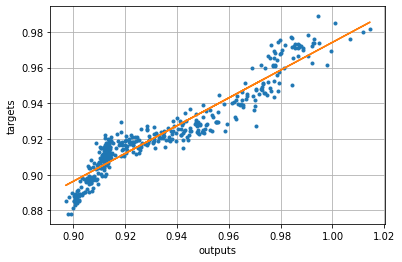

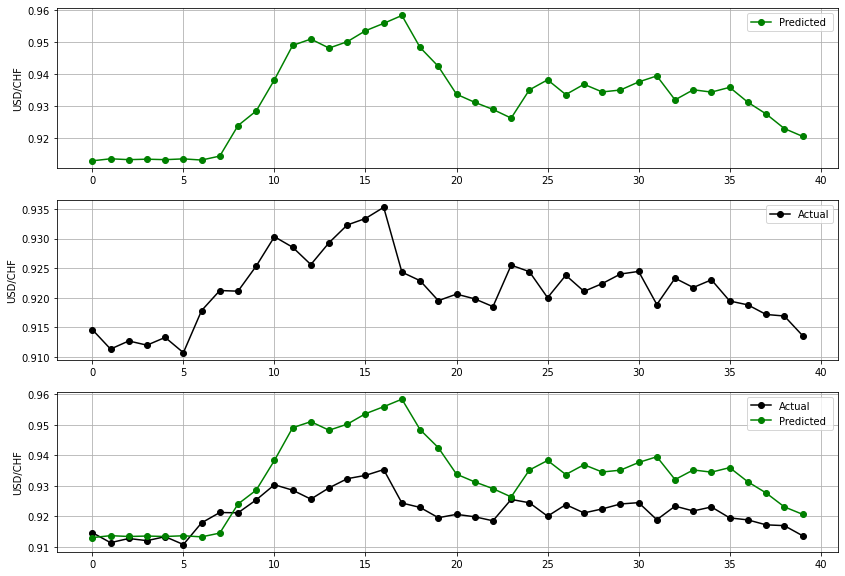

In [210]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 100)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 100)[1:] , label="val loss")
plt.legend()
plt.show()


outputs, targets, MSE = pl.evaluate(model_gru, test_x[:,:,0].reshape(-1, 10,1), test_y, device='cuda') 
pl.regression_result(targets,outputs)
ds.plot_result_price(outputs, targets, nb=40)

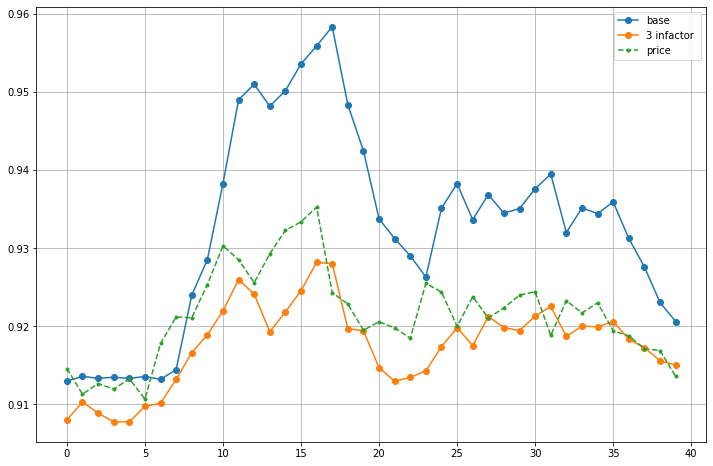

In [222]:

plt.figure(figsize=(12,8))
plt.plot(outputs[-40:],'o-', label="base")
plt.plot(o[-40:],'o-' , label="3 infactor ")
plt.plot(t[-40:],'.--', label="price")
plt.grid()
plt.legend()
plt.show()

In [117]:
train_x.shape

(3645, 10, 3)

### GRU (ALL features)

In [148]:

def min_max_norm(x_, y_): 
  y_ = y_.copy()
  min = x_.min(axis=1)
  max = x_.max(axis=1)
  d = []
 
  for i in range(3):
    res = (x_[:,:,i] - min[:,i].reshape(-1,1)) / (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))
    d.append(res.reshape(-1,10, 1))

  y_[:,0] = ((y_[:,0].reshape(-1,1) - min[:,0].reshape(-1,1))/ (max[:,0].reshape(-1,1) - min[:,0].reshape(-1,1))).reshape(-1,)
  return np.concatenate(d, axis=2), y_

train_x_norm, train_y_norm = min_max_norm(train_x, train_y)
val_x_norm, val_y_norm  = min_max_norm(val_x, val_y)
test_x_norm, test_y_norm = min_max_norm(test_x, test_y)



In [178]:
min = test_x.min(axis=1)
max = test_x.max(axis=1)


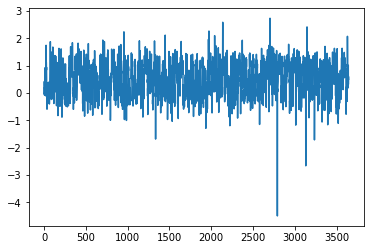

In [149]:
plt.plot(train_y_norm[:,0])

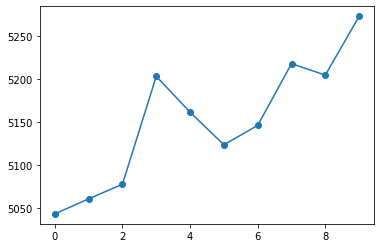

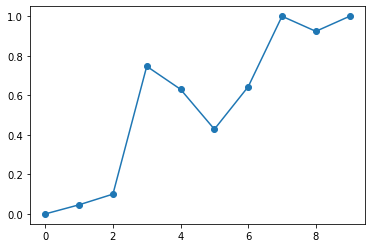

In [147]:
plt.plot(train_x[:10,-1,1], '-o')
plt.show()
plt.plot(train_x_norm[:10,-1,1], '-o')

In [168]:
model_gru_all = ml.GRU_base(
        hidden_size=32,
        num_layers=1,
        input_size=3,
        out_features_lin=32,
        out_features_end=1,
        dropout=0.05)
model_gru_all.to('cuda')
model_gru_all

GRU_base(
  (gru): GRU(3, 32, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=32, out_features=32, bias=True)
  (fc1_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [169]:
train_loss, val_loss = pl.train(model_gru_all, train_x_norm, train_y_norm, val_x_norm, val_y_norm, batch_size_=512, num_epochs_=40, lr=0.0001, device_='cuda')
# 0.005% score in validation 


 30%|███       | 12/40 [00:00<00:01, 22.61it/s]

Epoch: 8/40
MSE = [train loss mean :  0.69946951] , [val loss mean:  0.61426835, MSE (last) 62.03627%]


 45%|████▌     | 18/40 [00:00<00:00, 22.24it/s]

Epoch: 16/40
MSE = [train loss mean :  0.49742558] , [val loss mean:  0.63072224, MSE (last) 61.74465%]


 68%|██████▊   | 27/40 [00:01<00:00, 22.64it/s]

Epoch: 24/40
MSE = [train loss mean :  0.37492767] , [val loss mean:  0.59229516, MSE (last) 57.27273%]


 90%|█████████ | 36/40 [00:01<00:00, 22.37it/s]

Epoch: 32/40
MSE = [train loss mean :  0.29520477] , [val loss mean:  0.54516940, MSE (last) 52.49974%]


100%|██████████| 40/40 [00:01<00:00, 22.32it/s]

Epoch: 40/40
MSE = [train loss mean :  0.23855096] , [val loss mean:  0.50292760, MSE (last) 48.71814%]


In [184]:
o = outputs.reshape(-1,)  * (min[:,0]- max[:,0]) + min[:,0]
t = targets * (min[:,0]- max[:,0]) + min[:,0]
np.mean((o-t)**2)*100

0.004944035721497442

In [192]:
print(outputs.shape, targets.shape)

(451, 1) (451,)


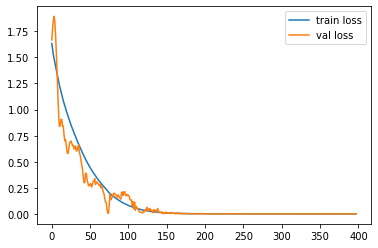

MSE: 21.873990566632944%
REAL MSE: 0.004944035721497442
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     7919.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):          2.46e-287
Time:                        22:46:07   Log-Likelihood:                 1722.9
No. Observations:                 451   AIC:                            -3442.
Df Residuals:                     449   BIC:                            -3434.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

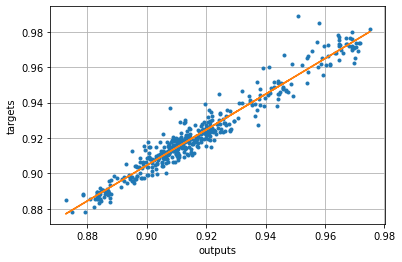

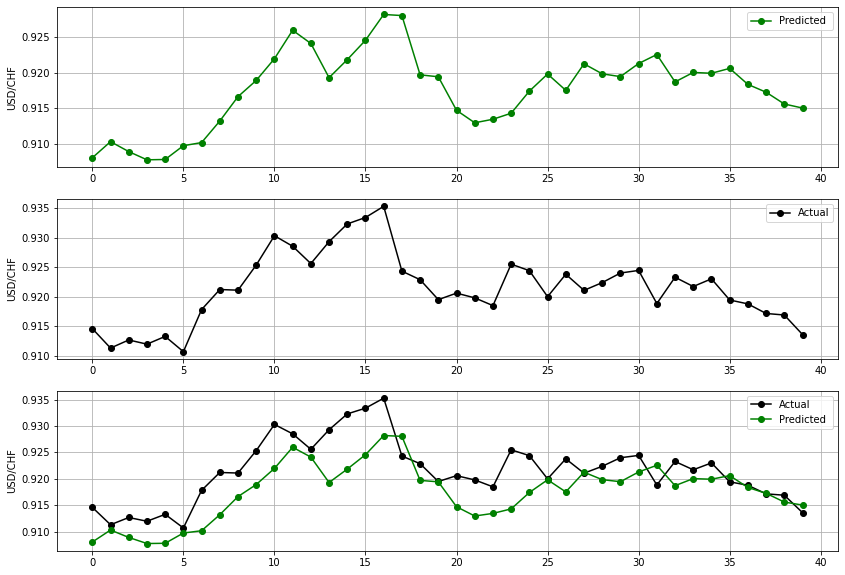

In [207]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 1)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 1)[1:] , label="val loss")
plt.legend()
plt.show()


outputs, targets, MSE = pl.evaluate(model_gru_all, test_x_norm, test_y_norm, device='cuda') 
o = outputs.reshape(-1,)* (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((o-t)**2)*100)

pl.regression_result(t,o)

ds.plot_result_price(o, t, nb=40)

#### Test for check normalisation...

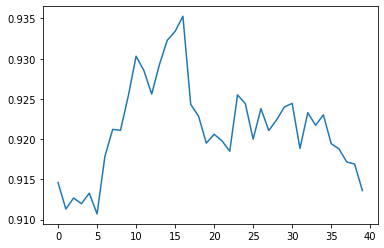

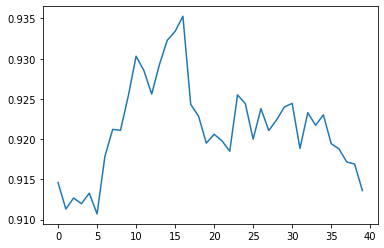

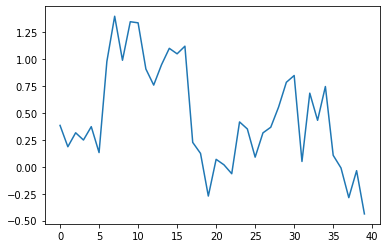

In [205]:
plt.plot(test_y[-40:,0])
plt.show()
min = test_x.min(axis=1)
max = test_x.max(axis=1)
plt.plot(test_y_norm[-40:,0] * (max[-40:,0] - min[-40:,0]) + min[-40:,0])
plt.show()
plt.plot(test_y_norm[-40:,0])